In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

In [1]:
### Download raw dataset

In [15]:
adata_ess_k562 = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/replogle/anndata/K562_essential_raw_singlecell_01.h5ad')
adata_ess_rpe1 = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/replogle/anndata/rpe1_raw_singlecell_01.h5ad')


### Perturbation filtering

In [2]:
supp2_ess_k562 = pd.read_excel('/dfs/project/perturb-gnn/datasets/replogle/anndata/supplement/1-s2.0-S0092867422005979-mmc2.xlsx',
                     sheet_name='TabB_K562_day6_summary_stat')

supp2_ess_rpe1 = pd.read_excel('/dfs/project/perturb-gnn/datasets/replogle/anndata/supplement/1-s2.0-S0092867422005979-mmc2.xlsx',
                     sheet_name='TabC_RPE1_summary_statistic')


In [3]:
## Following replogle conditions to get strong perts
def get_strong_perts(supp):
    filtered = supp[supp['Number of DEGs (anderson-darling)']>50]
    filtered = filtered[filtered['percent knockdown']<=-0.3]
    filtered = filtered[filtered['number of cells (filtered)']>25]
    strong_perts = filtered['genetic perturbation'].values
    strong_perts = [s.split('_')[1] for s in strong_perts]
    return strong_perts

In [4]:
strong_perts_ess_k562 = get_strong_perts(supp2_ess_k562)
strong_perts_ess_rpe1 = get_strong_perts(supp2_ess_rpe1)

In [5]:
len(strong_perts_ess_k562)

1092

In [6]:
len(strong_perts_ess_rpe1)

1564

In [36]:
strong_perts_ess_k562 = strong_perts_ess_k562 + ['non-targeting']
strong_perts_ess_rpe1 = strong_perts_ess_rpe1 + ['non-targeting']

#### Filter K562 perts

In [37]:
idx_to_keep = [v in strong_perts_ess_k562 for v in adata_ess_k562.obs['gene']]
pert_filter_k562 = adata_ess_k562[idx_to_keep]

In [38]:
print(len(adata_ess_k562))
print(len(adata_ess_k562.obs['gene'].unique()))

310385
2058


In [39]:
print(len(pert_filter_k562))
print(len(pert_filter_k562.obs['gene'].unique()))

192648
1093


#### Filter RPE1 perts

In [40]:
idx_to_keep = [v in strong_perts_ess_rpe1 for v in adata_ess_rpe1.obs['gene']]
pert_filter_rpe1 = adata_ess_rpe1[idx_to_keep]

In [41]:
print(len(adata_ess_rpe1))
print(len(adata_ess_rpe1.obs['gene'].unique()))

247914
2394


In [42]:
print(len(pert_filter_rpe1))
print(len(pert_filter_rpe1.obs['gene'].unique()))

175398
1544


### Remove cells that don't show knock down effect

In [8]:
##download_path = "https://plus.figshare.com/ndownloader/files/35775606"

In [93]:
def filter_cells_by_pert_effect(adata, k=10):
    
    perc_underk = []
    subset_idxs = []
    ctrl_adata = adata[adata.obs['gene'] == 'non-targeting']
    
    for itr, g in enumerate(adata.obs['gene'].unique()):        
        print(itr)
        subset = adata[adata.obs['gene'] == g]
        
        if g == 'non-targeting':
            subset_idxs.append(subset.obs.index.values)
            continue
        
        try:
            gene_loc = np.where(adata.var.gene_name == g)[0][0]
            thresh = np.percentile(ctrl_adata.X[:,gene_loc],k)
            perc_underk.append(sum(subset.X[:,gene_loc]>thresh))

            subset_idxs.append(subset.obs.index[subset.X[:,gene_loc]<=thresh].values)
        except:
            subset_idxs.append(subset.obs.index.values)
            
    subset_idxs = strong_perts = [item for sublist in subset_idxs for item in sublist]
    filtered_adata = adata[subset_idxs,:]
            
    return perc_underk, filtered_adata

In [94]:
perc_underk_ess_k562, filtered_adata_ess_k562 = filter_cells_by_pert_effect(pert_filter_k562)
perc_underk_ess_rpe1, filtered_adata_ess_rpe1 = filter_cells_by_pert_effect(pert_filter_rpe1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
118

In [100]:
filtered_adata_ess_k562.write_h5ad('/dfs/project/perturb-gnn/datasets/replogle/anndata/K562_essential_raw_singlecell_01_filtered.h5ad')
filtered_adata_ess_rpe1.write_h5ad('/dfs/project/perturb-gnn/datasets/replogle/anndata/rpe1_raw_singlecell_01_filtered.h5ad')



In [95]:
filtered_adata_ess_k562

View of AnnData object with n_obs × n_vars = 162751 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

In [96]:
filtered_adata_ess_rpe1

View of AnnData object with n_obs × n_vars = 162733 × 8749
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

Text(0, 0.5, 'Number of perturbations')

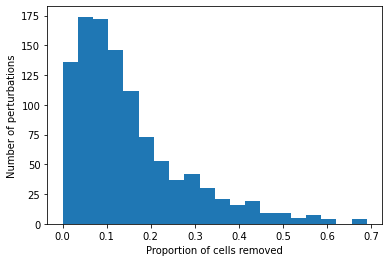

In [54]:
## Distribution over proportion of removed cells for apparent failed knockdown
_ = plt.hist(perc_under10, bins=20)
plt.xlabel('Proportion of cells removed')
plt.ylabel('Number of perturbations')

### Create dataloader

### All genes perturb seq: raw_value + count normalize + log transform

Cell line: RPE1

In [2]:
replogle_raw = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/replogle/anndata/K562_essential_raw_singlecell_01.h5ad')

In [3]:
sc.pp.normalize_total(replogle_raw)
sc.pp.log1p(replogle_raw)


sc.pp.highly_variable_genes(replogle_raw,n_top_genes=5000, subset=True)

In [5]:
replogle_raw.X = csr_matrix(replogle_raw.X)
replogle_raw.write_h5ad('/dfs/project/perturb-gnn/datasets/replogle/anndata/K562_essential_raw_singlecell_01_tot_log_hvg.h5ad')


### Reformatting h5ad

In [8]:
cell_type = 'K562'
adata = replogle_raw

In [9]:
adata.obs = adata.obs.rename(columns={'gene':'condition'})
adata.obs['condition'] = [c + '+ctrl' for c in adata.obs['condition']]
adata.obs['cell_type'] = cell_type
adata.obs = adata.obs.loc[:,['condition', 'cell_type']]

In [10]:
# Set condition names
mapper = {k:k for k in adata.obs['condition'].unique()}
mapper['non-targeting+ctrl'] = 'ctrl'
adata.obs['condition'] = adata.obs['condition'].map(mapper)

In [11]:
# Set cov_drug_dose_name names
adata.obs['cov_drug_dose_name'] = [cell_type+'_'+x+'_1+1' for x in adata.obs['condition']]
mapper = {k:k for k in adata.obs['cov_drug_dose_name'].unique()}
mapper['K562_ctrl_1+1'] = 'K562_ctrl_1'
adata.obs['cov_drug_dose_name'] = adata.obs['cov_drug_dose_name'].map(mapper)

In [12]:
# Compute differentially expressed genes
import sys
sys.path.append('/dfs/user/yhr/CPA_orig/')
from compert.helper import rank_genes_groups_by_cov

rank_genes_groups_by_cov(adata, groupby='cov_drug_dose_name', 
                         covariate='cell_type', control_group='ctrl_1', n_genes=20, use_raw=False)

K562


/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [13]:
import scipy
adata.X = scipy.sparse.csr_matrix(adata.X)

In [14]:
adata.write_h5ad('/dfs/project/perturb-gnn/datasets/replogle/anndata/K562_essential_raw_singlecell_01_tot_log_hvg_processed.h5ad')